# Time Series Analysis

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Exploring Bike Sharing data

In [207]:
# get the "Bike Sharing" dataset from OpenML
bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame
df.shape

(17379, 13)

In [208]:
df.describe()
# the count variable is the number of rental bikes per hour (our target)

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


[Text(0.5, 1.0, 'Average hourly bike demand during the week'),
 [Text(0, 0, 'Sun'),
  Text(24, 0, 'Mon'),
  Text(48, 0, 'Tue'),
  Text(72, 0, 'Wed'),
  Text(96, 0, 'Thu'),
  Text(120, 0, 'Fri'),
  Text(144, 0, 'Sat')],
 Text(0.5, 0, 'Time of the week'),
 Text(0, 0.5, 'Number of bike rentals')]

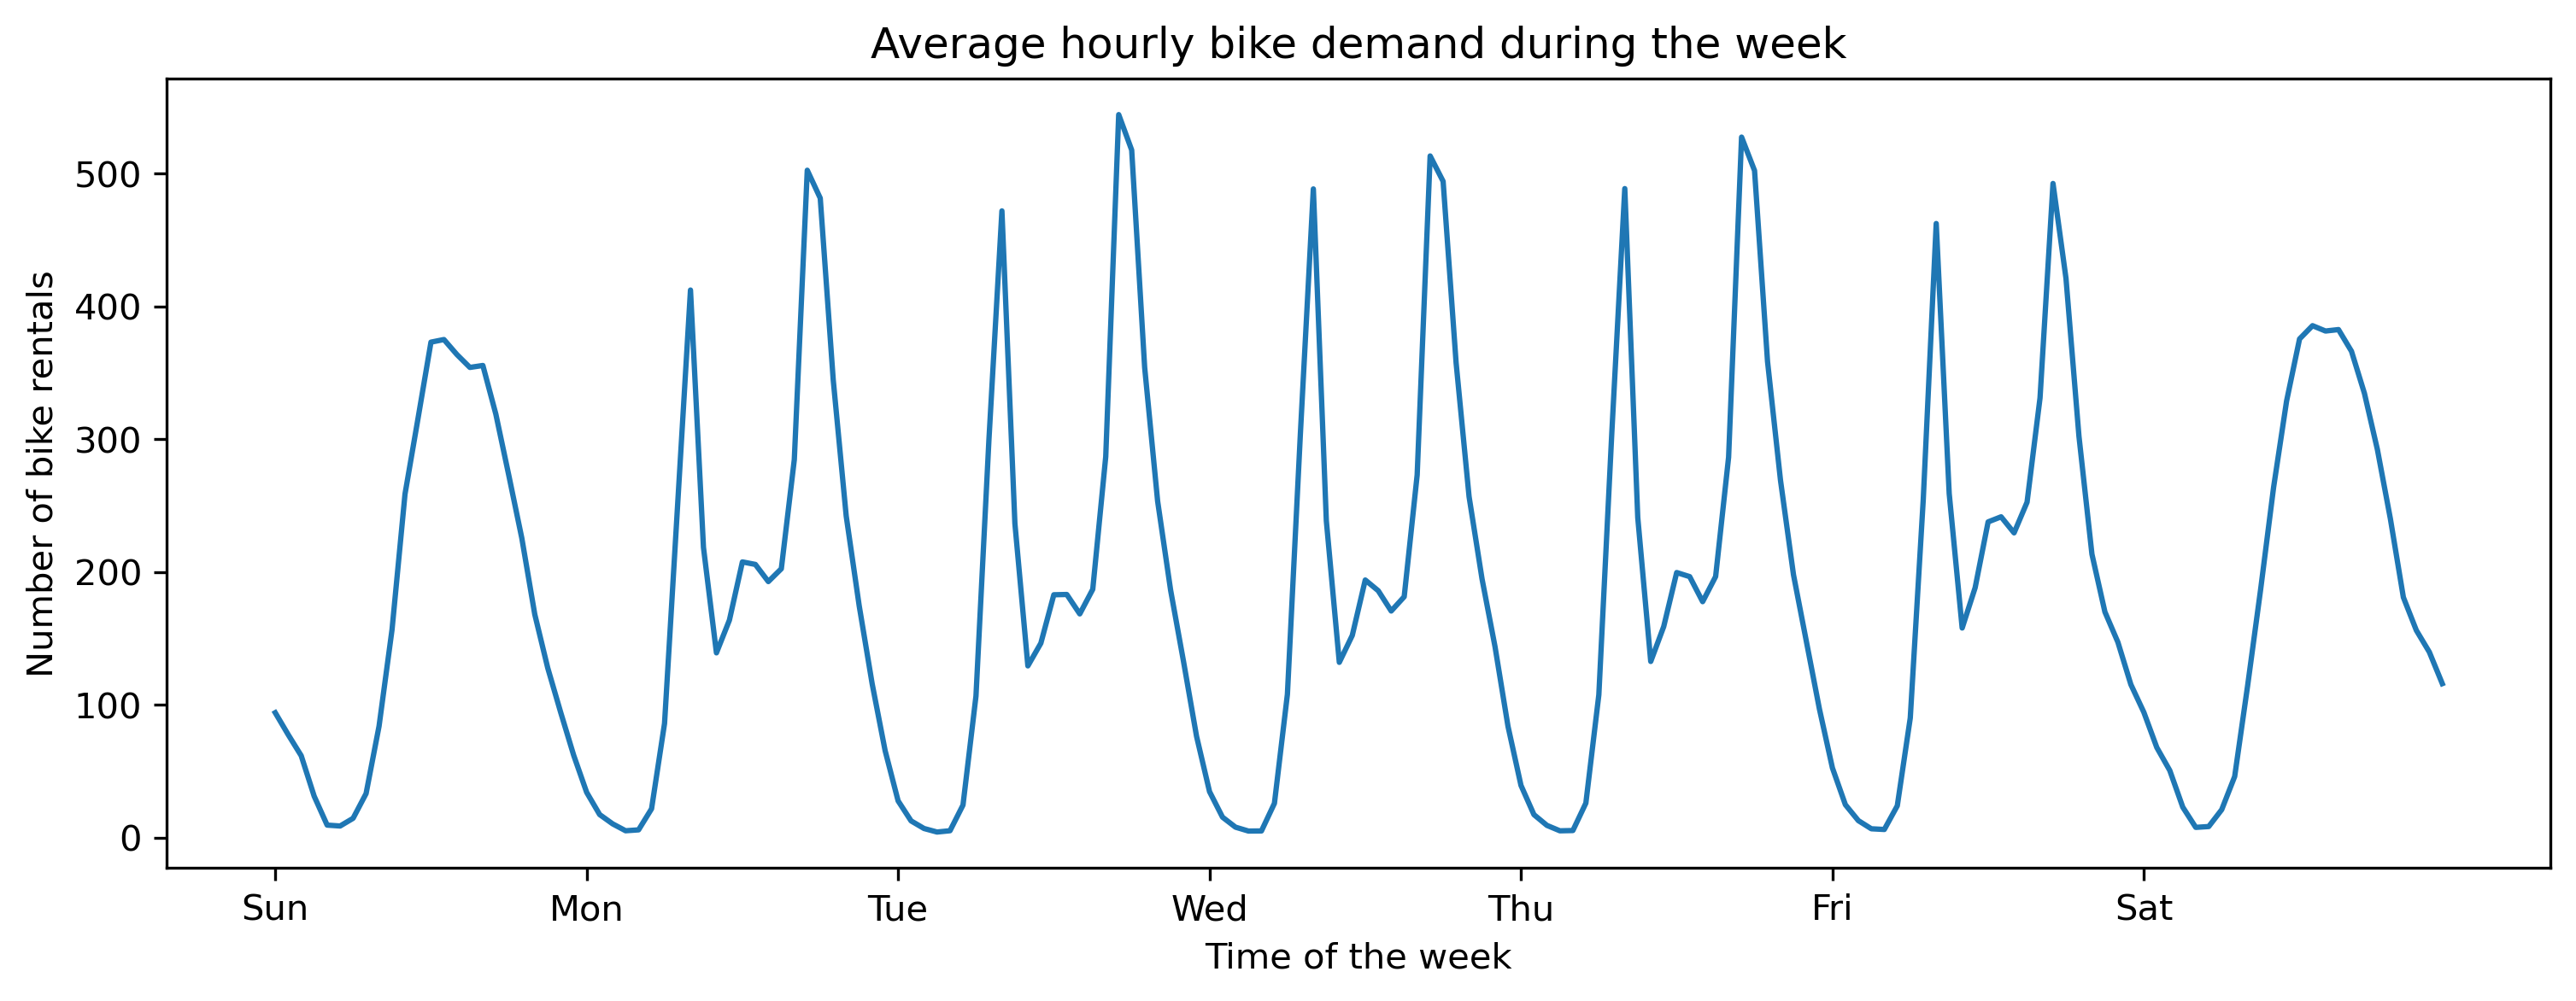

In [209]:
# plot the data for an average week

fig, ax = plt.subplots(figsize=(12, 4))
#average_week_demand = df.groupby(["weekday", "hour"]).mean()["count"]
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.head()
average_week_demand.plot(ax=ax)
ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [210]:
X = df
y = X.pop("count")

In [211]:
# exploration
X["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

In [212]:
X["weather"].value_counts()

weather
clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: count, dtype: int64

In [213]:
# data cleaning
X["weather"] = X["weather"].astype(str).replace("heavy_rain", "rain").astype("category")

X["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

# Time-based cross-validation

In [229]:
from sklearn.model_selection import TimeSeriesSplit

# Note: 
# the gap parameter allows us to excluded the last 48 hours of the training period
# we use a fixed training set size
tss = TimeSeriesSplit(n_splits=5,gap=48,max_train_size=10000,test_size=1000)

for train, test in tss.split(y):
    print("len train:",len(train),", len test",len(test), 
          ", indices train: [", np.min(train),",",np.max(train),"]", 
          ", indices test: [", np.min(test), ",", np.max(test),"]")
#you see, that the validation sets (here called test sets), are at the end of the time series

len train: 10000 , len test 1000 , indices train: [ 2331 , 12330 ] , indices test: [ 12379 , 13378 ]
len train: 10000 , len test 1000 , indices train: [ 3331 , 13330 ] , indices test: [ 13379 , 14378 ]
len train: 10000 , len test 1000 , indices train: [ 4331 , 14330 ] , indices test: [ 14379 , 15378 ]
len train: 10000 , len test 1000 , indices train: [ 5331 , 15330 ] , indices test: [ 15379 , 16378 ]
len train: 10000 , len test 1000 , indices train: [ 6331 , 16330 ] , indices test: [ 16379 , 17378 ]


## Encoding of categorical temporal variables

In [215]:
# data preparation 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]

categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]

ordinal_encoder = OrdinalEncoder(categories=categories)

cT = ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough"
)
cT.set_output(transform='pandas')
#the option set_output(transform='pandas') preserves the column names and gives a pandas dataframe as output

X2 = cT.fit_transform(X)

In [216]:
# let's check how it looks now
# X2.columns = X.columns
X2.describe()
#pd.DataFrame(X2,columns=X.columns).describe()

,categorical__weather,categorical__season,categorical__holiday,categorical__workingday,remainder__year,remainder__month,remainder__hour,remainder__weekday,remainder__temp,remainder__feel_temp,remainder__humidity,remainder__windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.425111,1.501640,0.028770,0.682721,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540
std,0.638796,1.106918,0.167165,0.465431,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500
50%,0.000000,2.000000,0.000000,1.000000,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000
75%,1.000000,2.000000,0.000000,1.000000,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900
max,2.000000,3.000000,1.000000,1.000000,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900


In [217]:
# model building: we use a linear regression model
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=np.logspace(-6, 6, 25))

In [218]:
# model evaluation
from sklearn.model_selection import cross_validate

def evaluate(model, X, y):
    ret = cross_validate(model, X, y, cv=tss, scoring=["neg_root_mean_squared_error"])
    rmse = -ret["test_neg_root_mean_squared_error"]
    print("%.2f ± %.2f" % (rmse.mean(), rmse.std()))

In [219]:
evaluate(model, X2, y)

180.63 ± 19.49


## One-hot encoding of periodic temporal variables

In [220]:
# try a different encoding of "hour", "weekday", "month"
# as separate one-hot variables

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

cT = ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder="passthrough"
).set_output(transform='pandas')

X2 = cT.fit_transform(X)
X2.head()

,categorical__weather_clear,categorical__weather_misty,categorical__weather_rain,categorical__season_fall,categorical__season_spring,categorical__season_summer,categorical__season_winter,categorical__holiday_False,categorical__holiday_True,categorical__workingday_False,...,one_hot_time__month_8,one_hot_time__month_9,one_hot_time__month_10,one_hot_time__month_11,one_hot_time__month_12,remainder__year,remainder__temp,remainder__feel_temp,remainder__humidity,remainder__windspeed
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,9.84,14.395,0.81,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,9.02,13.635,0.80,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,9.02,13.635,0.80,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,9.84,14.395,0.75,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,9.84,14.395,0.75,0.0


In [221]:
evaluate(model, X2, y)
# A significantly better fit

127.68 ± 10.39


# Trigonometric encoding of periodic temporal variables

In [222]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

cT = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder="passthrough"
).set_output(transform='pandas')
X2 = cT.fit_transform(X)
X2.head()

,categorical__weather_clear,categorical__weather_misty,categorical__weather_rain,categorical__season_fall,categorical__season_spring,categorical__season_summer,categorical__season_winter,categorical__holiday_False,categorical__holiday_True,categorical__workingday_False,...,month_cos__month,weekday_sin__weekday,weekday_cos__weekday,hour_sin__hour,hour_cos__hour,remainder__year,remainder__temp,remainder__feel_temp,remainder__humidity,remainder__windspeed
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.866025,-0.781831,0.62349,0.000000,1.000000,0,9.84,14.395,0.81,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.866025,-0.781831,0.62349,0.258819,0.965926,0,9.02,13.635,0.80,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.866025,-0.781831,0.62349,0.500000,0.866025,0,9.02,13.635,0.80,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.866025,-0.781831,0.62349,0.707107,0.707107,0,9.84,14.395,0.75,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.866025,-0.781831,0.62349,0.866025,0.500000,0,9.84,14.395,0.75,0.0


In [223]:
evaluate(model, X2, y)
# worse than one-hot, but better than ordinal encoding

161.92 ± 19.30


## Spline encoding of periodic temporal variables

In [224]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines):
    degree = 3
    n_knots = n_splines + 1  # since include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

cT = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=5), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=6), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=24), ["hour"]),
    ],
    remainder="passthrough"
).set_output(transform='pandas')
X2 = cT.fit_transform(X)
X2.describe()

,categorical__weather_clear,categorical__weather_misty,categorical__weather_rain,categorical__season_fall,categorical__season_spring,categorical__season_summer,categorical__season_winter,categorical__holiday_False,categorical__holiday_True,categorical__workingday_False,...,cyclic_hour__hour_sp_19,cyclic_hour__hour_sp_20,cyclic_hour__hour_sp_21,cyclic_hour__hour_sp_22,cyclic_hour__hour_sp_23,remainder__year,remainder__temp,remainder__feel_temp,remainder__humidity,remainder__windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.656712,0.261465,0.081823,0.258703,0.244088,0.253697,0.243512,0.971230,0.028770,0.317279,...,0.041909,0.041890,0.041890,0.041890,0.041890,0.502561,20.376474,23.788755,0.627229,12.736540
std,0.474820,0.439445,0.274103,0.437935,0.429557,0.435139,0.429214,0.167165,0.167165,0.465431,...,0.138538,0.138532,0.138532,0.138532,0.138532,0.500008,7.894801,8.592511,0.192930,8.196795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.940000,16.665000,0.480000,7.001500
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.500000,24.240000,0.630000,12.998000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,27.060000,31.060000,0.780000,16.997900
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.666667,0.666667,0.666667,0.666667,0.666667,1.000000,41.000000,50.000000,1.000000,56.996900


In [225]:
evaluate(model, X2, y)
# slightly better than one-hot encoding

126.90 ± 12.50
